# Formula 1 Dataset Analysis (2001~2024)

## Why data from 2001?
Formula 1 cars undergo regulation changes regularly. While regulation change is motivated for the drivers' safety, cost control, and closer competition, it affects the car performance massively - resetting constructor dominance every year.
In 2001, the massive regulation change was introduced - front & rear wing changes, crash standards tightening, driver aids, such as traction control, being reintroduced.   \
Because Formula 1 cars are different year by year, older data from 20th century may be irrelevant. Also, the oldest driver on the current grid, Fernando Alonso, joined Formula 1 in 2001, which makes 2001 a meaningful data. 

### Data
- **results**: race results, with starting positions and final result.
- **races**: information of each race
- **drivers**: information of each driver
- **qualifying**: information of qualifying session 
- **pit_stops**: data of pit stops during races
- **sprint_results**: sprint race results (introduced in 2021)
- **constructor_results**: race results of the constructor's championship
- **constructors**: information of constructors
- **status**: explanation for each statusId

### Loading packages and data

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.read_csv('./data/results.csv', na_values='\\N')
races = pd.read_csv('./data/races.csv', na_values='\\N')
drivers = pd.read_csv('./data/drivers.csv', na_values='\\N')
qualifying = pd.read_csv('./data/qualifying.csv', na_values='\\N')
pit_stops = pd.read_csv('./data/pit_stops.csv', na_values='\\N')
sprint_results = pd.read_csv('./data/sprint_results.csv', na_values='\\N')
constructor_results = pd.read_csv('./data/constructor_results.csv', na_values='\\N')

constructors = pd.read_csv('./data/constructors.csv')

### Clean data

#### Filtering years (2001~2024)   
Note: `raceId` does not represent the order of the race!

In [212]:
# filter year 2001~2024 (start by races.csv because it has year information)
races = races.loc[races['year'].isin(range(2001, 2025))].sort_values(by=['year', 'round']).reset_index(drop=True).sort_values(by=['year', 'round'])
# races.head(5)

valid_raceId = races['raceId'].unique()

# filter year for other datasets
results = results.loc[results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# results.head(5)

drivers = drivers.loc[drivers['driverId'].isin(results['driverId'])].sort_values(by='driverId').reset_index(drop=True)
# drivers.head(5)

qualifying = qualifying.loc[qualifying['raceId'].isin(valid_raceId)].sort_values(by=['qualifyId', 'position']).reset_index(drop=True)
qualifying.head(5)

pit_stops['time'] = pd.to_datetime(pit_stops['time'], format='%H:%M:%S').dt.time
# pit_stops.dtypes
pit_stops = pit_stops.loc[pit_stops['raceId'].isin(valid_raceId)].sort_values(by=['time']).reset_index(drop=True)
# pit_stops.head(5)

sprint_results['position'] = sprint_results['position'].astype('Int64') # int64 is used to handle \N (NA) values
sprint_results = sprint_results.loc[sprint_results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# sprint_results.dtypes => reveals that 'position' column is not in integer type, hindering the accurate sort order.
# sprint_results.dtypes
# sprint_results.head(10)

constructor_results = constructor_results.loc[constructor_results['raceId'].isin(valid_raceId)].sort_values(by=['constructorResultsId', 'constructorId']).reset_index(drop=True).dropna(axis=1)

#### Checking duplicates (Deduplication)

In [213]:
print(races.duplicated().sum())
print(results.duplicated().sum())
print(drivers.duplicated().sum())
print(qualifying.duplicated().sum())
print(pit_stops.duplicated().sum())
print(sprint_results.duplicated().sum())
print(constructor_results.duplicated().sum())
print(constructors.duplicated().sum())

0
0
0
0
0
0
0
0


Great, it seems there are no duplicates in these data!


## EDA

### Constructors 

#### Constructors Dominance

In [214]:
races_const_merged = pd.merge(races, constructor_results, on='raceId', how='outer', suffixes=('','_races')).sort_values(by=['year', 'round']).reset_index(drop=True)
races_const_merged = races_const_merged.dropna(axis=1)

constructor_points_sum = races_const_merged.groupby(['year', 'constructorId'])['points'].sum().reset_index().sort_values(by=['year', 'constructorId'])

# Since there are too many constructors, I need to select a few. 
# I choose Ferrari, Renault, Brawn, Redbull, and Mercedes

# Retrieve constructorIds for these teams
selected_const = ['ferrari', 'renault', 'red_bull', 'mercedes', 'brawn', 'mclaren']
selected_const_id = constructors.loc[constructors['constructorRef'].isin(selected_const), ['constructorRef', 'constructorId']].reset_index(drop=True)
selected_const_id

,constructorRef,constructorId
0,mclaren,1
1,renault,4
2,ferrari,6
3,red_bull,9
4,brawn,23
5,mercedes,131


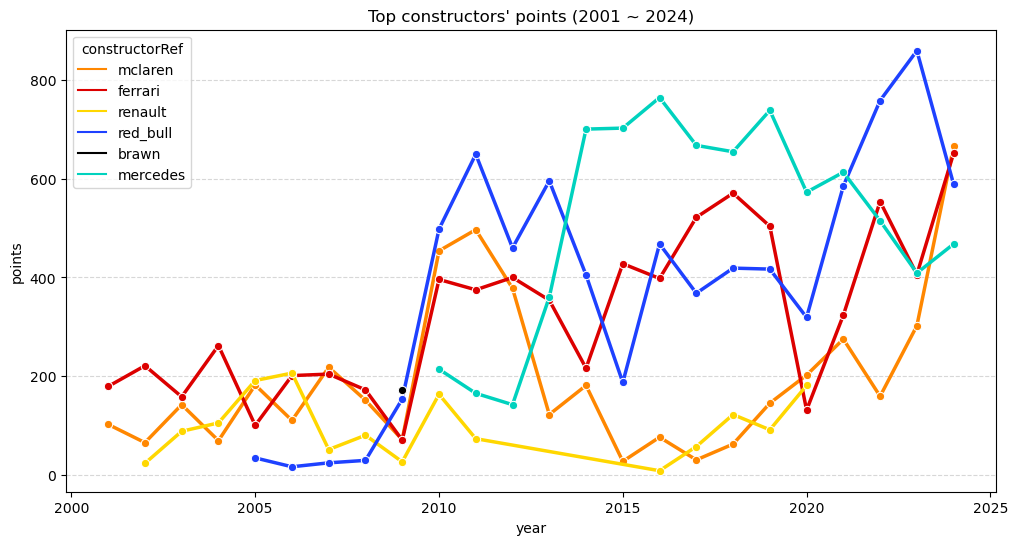

In [215]:
# keep constructors in selected_const_id
constructor_points_sum = constructor_points_sum.loc[constructor_points_sum['constructorId'].isin(selected_const_id['constructorId'])]
# merge selected_const_id and constructor_points_sum on 'constructorId'
constructor_points_sum = constructor_points_sum.merge(selected_const_id, how='left', on='constructorId').sort_values(by=['year', 'constructorId'])

# visualize

custom_color = {
    'mercedes': '#00D2BE',
    'ferrari': '#DC0000',
    'red_bull': '#1E41FF',
    'mclaren': '#FF8700',
    'renault': '#FFD700',
    'brawn': '#000000'
}
plt.figure(figsize=(12, 6))
sns.lineplot(data=constructor_points_sum, x='year', y='points', hue='constructorRef', marker='o', linewidth=2.5, palette=custom_color)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title("Top constructors' points (2001 ~ 2024)")
plt.show()

- From 2001 to 2009, you can clearly see that Ferrari was dominant, except for 2005 and 2006, when Fernano Alonso (the GOAT) took two championships.  
- Brawn GP (Honda GP until 2008 and Mercedes AMG since 2010) only appeared in 2009.
- From 2010 to 2013, Red Bull Racing was dominant with Sebastian Vettel.
- However, from 2014 to 2021, Mercedes AMG Petronas was very dominant.
- Again, from 2022 to 2023, red bull racing won the constructors championship.
- At the end of the graph, you can see Red Bull Racing's rapid drop in performance, which is still undergoing. 
- Mclaren's recent performance is impressive. Before 2021, Mclaren used Honda Engine and underperformed. They were able to turn the table after agreement with Mercedes on the usage of their engine. Mclaren's performance is still mind-blowing to this day (2025).

### Drivers

#### Qualifying positions and race result correlation

In [216]:
# drop columns that are irrelevant for this analysis: col q1 to q3
qualifying_mod = qualifying.drop(['q1', 'q2', 'q3'], axis=1)
# merge results df and qualifying_mod df
qual_res_merged = qualifying_mod.merge(
    results,
    how='left',
    on=['raceId', 'driverId', 'constructorId'],
    suffixes=('_qualifying', '_race')
)

correlation = qual_res_merged['position_qualifying'].corr(qual_res_merged['position_race'])
print(f'Correlation between qualifying position and race result: {correlation:.3f}')

Correlation between qualifying position and race result: 0.761


We got **0.761**.   
0 means there is no linear relationship, while 1 means strong positive relationship (good qualifying -> good result)

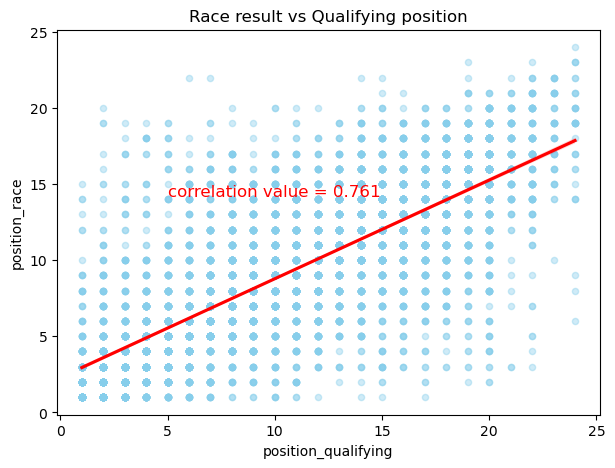

In [217]:
# We are analyzing relationship between the two variables. Regression plot will do for visualization.
plt.figure(figsize=(7, 5))
sns.regplot(
    data=qual_res_merged,
    x='position_qualifying',
    y='position_race',
    scatter_kws={'alpha': 0.4, 's':20, 'color':'skyblue'},
    line_kws={'color':'red'}
)
plt.text(5, 15,
         f"correlation value = {correlation:.3f}",
         fontsize=12,
         va='top',
         color='red')
plt.title('Race result vs Qualifying position')
plt.show()

This is a visualized version.    


To conclude, 
1. We can see positive relationship between starting position and result.  
2. For deeper insights, considering race results with DNF (`NaN`) will be crucial. 

#### Average position gain/loss

In [218]:
qual_res_merged['position_gain'] = qual_res_merged['position_qualifying'] - qual_res_merged['position_race']
driver_avg_gain = qual_res_merged.groupby('driverId')['position_gain'].mean().sort_values(ascending=False).reset_index().rename(columns={'position_gain': 'avg_position_gain'}).dropna(axis=0)
driver_avg_gain = driver_avg_gain.merge(drivers[['driverId', 'driverRef']], how='left', on='driverId')

print(driver_avg_gain)
print(driver_avg_gain['avg_position_gain'].describe())

     driverId  avg_position_gain driverRef
0          66          12.000000    mcnish
1          34           9.000000       ide
2          56           7.000000    irvine
3          61           7.000000      enge
4          53           6.600000     kiesa
..        ...                ...       ...
113         3           0.197740   rosberg
114       857           0.162791   piastri
115       846           0.000000    norris
116       822          -0.154545    bottas
117        48          -0.333333      gene

[118 rows x 3 columns]
count    118.000000
mean       2.572065
std        1.920040
min       -0.333333
25%        1.255147
50%        2.116883
75%        3.510244
max       12.000000
Name: avg_position_gain, dtype: float64


Now here's the problem. I am trying to see the average gain/loss of the drivers.  
However, some drivers have raced in Formula One once or only few times, as a reserve driver or test driver. This kind of drivers may have unrealistic average position gain.
This may make the result inaccurate.   
Therefore, I will implement **z-score** to rule out the outliers (entries outside of +/- 3 standard deviation)

<Axes: >

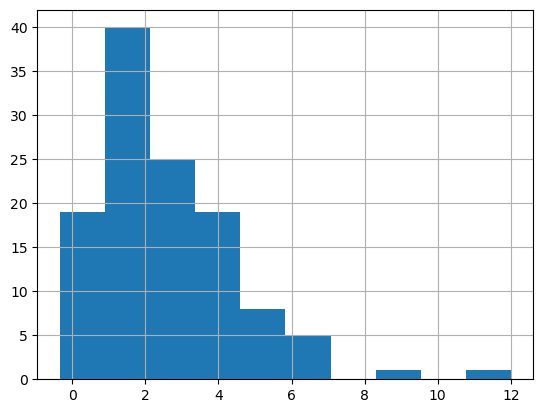

In [219]:
# First, lets visualize how the values are distributed.
driver_avg_gain['avg_position_gain'].hist()

In [220]:
# There are clearly outliers. 
# Let's import scipy.stats package to calculate z-score.

import scipy.stats as stats
driver_avg_gain['z_score'] = stats.zscore(driver_avg_gain['avg_position_gain'])

driver_avg_gain = driver_avg_gain.loc[driver_avg_gain['z_score'].abs() <= 3]
driver_avg_gain

,driverId,avg_position_gain,driverRef,z_score
2,56,7.000000,irvine,2.316003
3,61,7.000000,enge,2.316003
4,53,6.600000,kiesa,2.106786
5,59,6.000000,bernoldi,1.792960
6,812,5.888889,chandhok,1.734844
...,...,...,...,...
113,3,0.197740,rosberg,-1.241875
114,857,0.162791,piastri,-1.260155
115,846,0.000000,norris,-1.345302
116,822,-0.154545,bottas,-1.426136


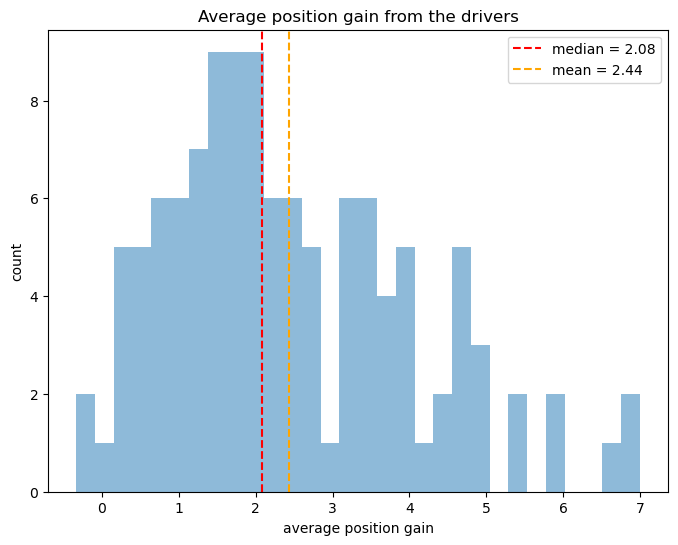

In [235]:
# histogram is great for showing distribution.
median = driver_avg_gain['avg_position_gain'].median()
mean = driver_avg_gain['avg_position_gain'].mean()

plt.figure(figsize=(8, 6))
sns.histplot(data=driver_avg_gain, x='avg_position_gain', bins=30, alpha=0.5, edgecolor='none')
plt.axvline(x=median, color='red', linestyle='--', label=f'median = {median:.2f}')
plt.axvline(x=mean, color='orange', linestyle='--', label=f'mean = {mean:.2f}')
plt.title('Average position gain from the drivers')
plt.xlabel('average position gain')
plt.ylabel('count')
plt.legend()
plt.show()

The median value for `avg_position_gain` is 2.08, and mean value is 2.44.    
We can see that many drivers have average position gain of around 1~3, which makes sense.    
Gaining positions in Formula One is extremely challenging and depends on countless factors, such as team strategy and weather fluctuations.

### Top causes for **DNF**

In [237]:
# For this analysis, we need to import status.csv, which contains status name for each statusId.
status = pd.read_csv('./data/status.csv')
status.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
